# Distributed BlazingSQL + Datashader 
In this notebook we will:
1. Download 12 months of NYC Yellow Cab Taxi data (~22.88GB total) from AWS. 
2. Preprocess / ETL all months at the same time by distributing BlazingSQL across 4 16GB Tesla T4 GPUs.
3. Pass preprocessed data directly to Datashader for visualization.

#### Prerequisites 
To run this notebook you simply need to have [Datashader installed](https://datashader.org/getting_started/index.html#installation) and 2+ [RAPIDS compatible GPUs](https://medium.com/dropout-analytics/which-gpus-work-with-rapids-ai-f562ef29c75f?source=friends_link&sk=3ad1082fbd38df262bf04c164dbb3c0a) set up.

#### Imports

In [1]:
import os
import sys
import urllib

# distributed BlazingSQL imports 
from dask_cuda import LocalCUDACluster
from dask.distributed import Client
from blazingsql import BlazingContext

# datashader visualization imports 
import datashader as ds
from colorcet import fire
from datashader import transfer_functions as tf

### Data Download / Check 
The cell below will download the full year of 2015 yellow cab data.
- Full data download Wall time: 4min 43s on AWS EC2
- Size: ~22.88GB total (12 CSV files, January-December)

In [2]:
%%time
def data_check(file_name, base_url='https://s3.amazonaws.com/nyc-tlc/trip+data/', data_dir='data/'):
    """
    1. check if the given {file_name} exists locally in {data_dir}
    2. download from {base_url} & save in {data_dir) if not
    """
    # tag cloud & relative local paths to data
    local_data = data_dir + file_name
    cloud_data = base_url + file_name
    # do we already have the file?
    if not os.path.isfile(local_data):
        # we don't, let me know we're downloading it now, then download it
        print(f'Downloading http://{cloud_data[8:]} to {local_data}')
        urllib.request.urlretrieve(cloud_data, local_data)
    # we already have data
    else:
        # let me know this is the case
        print(f'{local_data} already downloaded')

        
# january - december
for month in range(1, 13):
    # check if we are in double digit months
    if month < 10:
        # add 0 so we have the correct path
        month = f'0{month}'
    # tag file name for this month (default year to 2015)
    fn = f'yellow_tripdata_2015-{month}.csv'
    # check this month's data for 2015 
    data_check(file_name=fn)

data/yellow_tripdata_2015-01.csv already downloaded
data/yellow_tripdata_2015-02.csv already downloaded
data/yellow_tripdata_2015-03.csv already downloaded
data/yellow_tripdata_2015-04.csv already downloaded
data/yellow_tripdata_2015-05.csv already downloaded
data/yellow_tripdata_2015-06.csv already downloaded
data/yellow_tripdata_2015-07.csv already downloaded
data/yellow_tripdata_2015-08.csv already downloaded
data/yellow_tripdata_2015-09.csv already downloaded
data/yellow_tripdata_2015-10.csv already downloaded
data/yellow_tripdata_2015-11.csv already downloaded
data/yellow_tripdata_2015-12.csv already downloaded
CPU times: user 1.12 ms, sys: 51 µs, total: 1.17 ms
Wall time: 708 µs


## Distributed BlazingSQL
We're now ready to distribute BlazingSQL and preprocess our data.

In [3]:
# tag the local GPU cluster & extract the client
cluster = LocalCUDACluster()
client = Client(cluster)

# what's the client look like?
client

Client Scheduler: tcp://127.0.0.1:43737 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 16.51 GB


In [4]:
# pass in client to connect to BlazingSQL distributed 
bc = BlazingContext(dask_client=client, network_interface='lo')

BlazingContext ready


#### Create a Table
In the next cell, we'll create 1 table to hold all 12 of the taxi files. This is just like creating a table on with default (non-distributed) BlazingSQL.

In [5]:
# ID file path of this notebook & add relative path to data w/ wildcard (*)
cwd = os.getcwd()
data_path = f'{cwd}/data/yellow_tripdata_2015*.csv'

# create 1 table from all 12 months 
bc.create_table('big_taxi', data_path, header=0)

## Query a Table & Hand off Results 
With our table created, all that remains is defining & running a query, and passing off the results. 

Thanks to Datashader's GPU support, we can pass `bc.sql()` directly in for near-instant visualization. 

In the cells below we will:
1. Define our ETL query -- this query will preprocess the data so it can be correctly displayed by Datashader.
2. Query the `big_taxi` table, passing the dask_cuDF DataFrame results to Datashader's `.Canvas()`.
3. Call Datashader's `transfer_functions` to shade in the graph & visualize results.

In [6]:
# tag pi & origin shift
pi = 3.141592653589793
o_shift = 2 * pi * 6378137 / 2

# filter data to select dropoff coordinate regions and recalculate lat & lng columns
query = f'''
        SELECT 
            dropoff_longitude * {o_shift} / 180 AS dropoff_x, 
            LOG10(TAN(((90 + dropoff_latitude) * {pi} / 360))) / {pi} / 180 * {o_shift} / 180 AS dropoff_y
        FROM 
            big_taxi
            WHERE
                dropoff_longitude < -73.75 AND dropoff_longitude > -74.15
                AND dropoff_latitude > 40.68 AND dropoff_latitude < 40.84
                '''

In [7]:
%%time
# execute query & lay out the canvas w/ dropoff locations 
agg = ds.Canvas().points(bc.sql(query), 'dropoff_x', 'dropoff_y')

CPU times: user 1.37 s, sys: 129 ms, total: 1.5 s
Wall time: 13.8 s


CPU times: user 408 ms, sys: 15.5 ms, total: 424 ms
Wall time: 417 ms


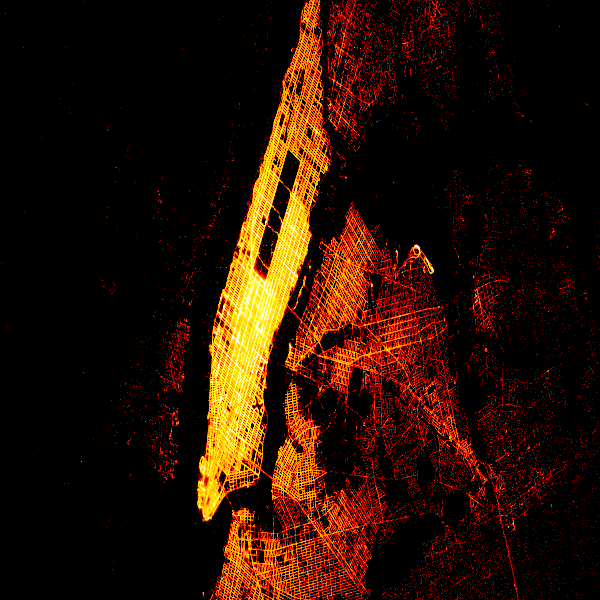

In [8]:
%%time
# shade in the picture w/ fire & display
tf.set_background(tf.shade(agg, cmap=fire), "black")